In [4]:
%reset -f

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from optbinning import OptimalBinning
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegressionCV
from joblib import Parallel, delayed
from itertools import combinations

In [6]:
# Setting up file paths 
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

In [7]:
# Loading data

FILE_PATH_DATA = project_root / 'data' / 'raw' / 'accepted_2007_to_2018Q4.csv.gz'
FILE_PATH_DICTIONARY = project_root / 'data' / 'raw'/ 'dictionary_approved_raw.csv' 

df = pd.read_csv(FILE_PATH_DATA, compression = 'gzip', low_memory = False)
df_dictionary = pd.read_csv(FILE_PATH_DICTIONARY, usecols = [0,1], low_memory = False)


In [8]:
# Comparing Data to Dictionary

data_columns = set(df.columns)
dictionary_columns = set(df_dictionary.iloc[:, 0].astype(str).str.strip())

common = data_columns.intersection(dictionary_columns)
in_data_only = data_columns - dictionary_columns
in_dict_only = dictionary_columns - data_columns

print(f"Total columns in Dataset: {len(data_columns)}")
print(f"Total variables in Dictionary: {len(dictionary_columns)}")
print(f"Matches found: {len(common)}\n")

print("-" * 30)
print(f"Columns in DATA but not in Dictionary ({len(in_data_only)}):")
print(list(in_data_only))

print("-" * 30)
print(f"Columns in DICTIONARY but not in Data ({len(in_dict_only)}):")
print(list(in_dict_only))

Total columns in Dataset: 151
Total variables in Dictionary: 152
Matches found: 150

------------------------------
Columns in DATA but not in Dictionary (1):
['verification_status_joint']
------------------------------
Columns in DICTIONARY but not in Data (2):
['verified_status_joint', 'nan']


In [9]:
# Make sure the names of the features match

df_dictionary.iloc[:, 0] = df_dictionary.iloc[:, 0].replace('verified_status_joint', 'verification_status_joint')
df_dictionary = df_dictionary.dropna()

In [10]:
# Save cleaned dictionary
FILE_PATH_DICTIONARY_CLEANED = project_root / 'data' / 'cleaned'/ 'dictionary_approved_cleaned.csv'

df_dictionary.to_csv(FILE_PATH_DICTIONARY_CLEANED)

In [11]:
FILE_PATH = project_root / 'data' / 'accepted_2007_to_2018Q4.csv.gz'

cols_to_keep = [
    # Target
    'loan_status',

    # Structural / Lender Features (Known at Origination)
    'term', 'loan_amnt', 'initial_list_status', 'application_type', 'installment',

    # Applicant Features (The core data)
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'dti', 'delinq_2yrs', 
    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'mths_since_last_delinq',
    'fico_range_low', 'fico_range_high',

    # Dates
    'issue_d', 'earliest_cr_line'
]
df = df[cols_to_keep]

df['fico_average'] = (df['fico_range_high'] - df['fico_range_low'] )/ 2
df = df.drop(columns = ['fico_range_high', 'fico_range_low'])

In [12]:
# Checking data types for cleaning

print(df.dtypes)

object_cols = df.select_dtypes(include=['object']).columns

for col in object_cols:
    num_unique = df[col].nunique()
    
    print(f"Column: {col}")
    print(f"Count of unique values: {num_unique}")
    
    if num_unique < 50:
        print(f"Values: {df[col].unique()}")
    else:
        print(f"Top 10 values: {df[col].value_counts().head(10).index.tolist()}")
    
    print("-" * 30)

loan_status                object
term                       object
loan_amnt                 float64
initial_list_status        object
application_type           object
installment               float64
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
purpose                    object
dti                       float64
delinq_2yrs               float64
inq_last_6mths            float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
mort_acc                  float64
pub_rec_bankruptcies      float64
mths_since_last_delinq    float64
issue_d                    object
earliest_cr_line           object
fico_average              float64
dtype: object
Column: loan_status
Count of unique values: 9
Values: ['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Lat

In [13]:
# Turning all variables into int or float usable types

target_statuses = [
    'Fully Paid', 
    'Charged Off', 
    'Default', 
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status:Charged Off'
]

df = df[df['loan_status'].isin(target_statuses)].copy()

# target
bad_indicators = [
    'Charged Off', 
    'Default', 
    'Does not meet the credit policy. Status:Charged Off',
]
df['target'] = np.where(df['loan_status'].isin(bad_indicators), 1, 0)
df = df.drop(columns=['loan_status'])

term_map = {' 36 months': 1, ' 60 months': 2}
df['term_rank'] = df['term'].map(term_map)
df = df.drop(columns=['term'])

initial_list_status_map = {'w': 0, 'f': 1}
df['initial_list_status_f'] = df['initial_list_status'].map(initial_list_status_map)
df = df.drop(columns=['initial_list_status'])

application_type_map = {'Joint App': 0, 'Individual': 1}
df['individual_application'] = df['application_type'].map(application_type_map)
df = df.drop(columns=['application_type'])

df['emp_length_years'] = df['emp_length'].str.replace('< 1', '0').str.extract(r'(\d+)')
df['emp_length_years'] = pd.to_numeric(df['emp_length_years'], errors='coerce')
df = df.drop(columns=['emp_length'])

dummy_cols = ['home_ownership', 'purpose', 'verification_status']
df = pd.get_dummies(df, columns=dummy_cols, drop_first=True, dtype=int)

# Engineering date to get time since first credit lite
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['credit_hist_months'] = ((df['issue_d'] - df['earliest_cr_line']) / pd.Timedelta(days=30))

# Normalise column names
df.columns = df.columns.str.replace(' ', '_').str.lower()


categorical_columns = [
    'target',
    'term_rank',
    'initial_list_status_f',
    'individual_application',
    'emp_length_years',
    'home_ownership_mortgage', 
    'home_ownership_none',
    'home_ownership_other',
    'home_ownership_own',
    'home_ownership_rent',
    'verification_status_source_verified',
    'verification_status_verified',
    'purpose_credit_card',
    'purpose_debt_consolidation',
    'purpose_educational',
    'purpose_home_improvement',
    'purpose_house',
    'purpose_major_purchase',
    'purpose_medical',
    'purpose_moving',
    'purpose_other',
    'purpose_renewable_energy',
    'purpose_small_business',
    'purpose_vacation',
    'purpose_wedding'
]

missing_categorical_cols = [col for col in categorical_columns if col not in df.columns]

if missing_categorical_cols:
    print(f"Warning: The following columns were not found in df: {missing_categorical_cols}")
else:
    print("All columns present")
    print(df.dtypes)

All columns present
loan_amnt                                     float64
installment                                   float64
annual_inc                                    float64
dti                                           float64
delinq_2yrs                                   float64
inq_last_6mths                                float64
open_acc                                      float64
pub_rec                                       float64
revol_bal                                     float64
revol_util                                    float64
total_acc                                     float64
mort_acc                                      float64
pub_rec_bankruptcies                          float64
mths_since_last_delinq                        float64
issue_d                                datetime64[ns]
earliest_cr_line                       datetime64[ns]
fico_average                                  float64
target                                          int64
term_ran

In [14]:
# Brute force feature engineering

# Configuration
IV_THRESHOLD = 0.02
N_JOBS = 8

# Setup Data
float_cols = df.select_dtypes(include=['float64']).columns
df[float_cols] = df[float_cols].astype(np.float32)

target = df['target'].values
non_predictive = ['target', 'issue_d', 'earliest_cr_line']
features = [col for col in df.columns if col not in non_predictive]

print(f"Starting parallel IV screening on {len(features)} base features...")

# Worker Function
def process_pair_ops(v1, v2, col_v1, col_v2, target, threshold):
    results = []
    
    # Context manager suppresses "RuntimeWarning: divide by zero encountered"
    with np.errstate(divide='ignore', invalid='ignore'):
        ops = {
            f"{v1}_x_{v2}": col_v1 * col_v2,
            f"{v1}_div_{v2}": col_v1 / col_v2,
        }

    for name, data in ops.items():
        try:
            if np.isnan(data).all():
                continue

            optb = OptimalBinning(
                name=name,
                dtype="numerical",
                solver="cp",
                monotonic_trend="auto_asc_desc",
                min_bin_size=0.05,
                max_pvalue=0.05
            )
            
            # If infs cause fitting issues, the try-except block will catch it and skip
            optb.fit(data, target)
            iv = optb.binning_table.build().loc['Totals', 'IV']
            
            if iv > threshold:
                results.append((name, iv, data))
                
        except Exception:
            # Optbinning may fail on specific distributions of inf; we skip those.
            continue
            
    return results if results else None

# Parallel Execution
results_nested = Parallel(n_jobs=N_JOBS, verbose=5)(
    delayed(process_pair_ops)(
        v1, v2, df[v1].values, df[v2].values, target, IV_THRESHOLD
    ) for v1, v2 in combinations(features, 2)
)

# Aggregation
valid_results = []
if results_nested:
    for res in results_nested:
        if res:
            valid_results.extend(res)

if valid_results:
    # Unpack results
    names = [r[0] for r in valid_results]
    iv_values = [r[1] for r in valid_results]
    data_arrays = [r[2] for r in valid_results]
    
    # Create DataFrames
    df_new_features = pd.DataFrame(dict(zip(names, data_arrays)), index=df.index)
    df_iv_summary = pd.DataFrame({'feature': names, 'iv': iv_values}).sort_values('iv', ascending=False)
    
    # Merge
    df = pd.concat([df, df_new_features], axis=1)
    
    print("\nProcessing Complete.")
    print(f"Total new features added: {len(df_new_features.columns)}")
    print(df_iv_summary.head(10))
else:
    print("\nNo features met the threshold.")

Starting parallel IV screening on 40 base features...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   19.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   35.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   45.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 780 out of 780 | elapsed:  1.5min finished



Processing Complete.
Total new features added: 148
                                    feature        iv
49                          dti_x_term_rank  0.197865
117              fico_average_div_term_rank  0.173656
116                fico_average_x_term_rank  0.173622
122      term_rank_x_individual_application  0.167713
35                 annual_inc_div_term_rank  0.155837
1                 loan_amnt_div_installment  0.148001
90                   revol_util_x_term_rank  0.133846
10                    loan_amnt_x_term_rank  0.117282
125         term_rank_x_home_ownership_rent  0.111498
126  term_rank_x_purpose_debt_consolidation  0.110695


In [15]:
# Define cutoff for Out-of-Time (OOT) validation
oot_cutoff = pd.Timestamp('2015-01-01')

df_train = df[df['issue_d'] < oot_cutoff].copy()
df_oot = df[df['issue_d'] >= oot_cutoff].copy()

print("\n--- Split Summary ---")
print(f"Train/Test Volume: {len(df_train)}")
print(f"OOT Volume: {len(df_oot)}")
print(f"OOT Default Rate: {df_oot['target'].mean():.2%}")

df = df.drop(columns=['issue_d', 'earliest_cr_line'])
issue_dates_train = df_train['issue_d']
df_train = df_train.drop(columns=['issue_d', 'earliest_cr_line'])
df_oot = df_oot.drop(columns=['issue_d', 'earliest_cr_line'])


--- Split Summary ---
Train/Test Volume: 453809
OOT Volume: 894290
OOT Default Rate: 21.48%


In [16]:
# Proportion of target values

print(f"Filtered Shape: {df.shape}")
print("\nTarget Distribution:")
print(df['target'].value_counts(normalize=True))

Filtered Shape: (1348099, 189)

Target Distribution:
target
0    0.800193
1    0.199807
Name: proportion, dtype: float64


In [17]:
# Save checkpoints
df_train.to_pickle('data_train.pkl')
df_oot.to_pickle('data_oot.pkl')

In [18]:
# Identify Categorical vs Numerical variables
target_col = 'target'

# Select features (excluding target and ignored cols)
features = [c for c in df_train.columns if c not in [target_col]]

num_cols = df_train[features].select_dtypes(include=['number']).columns.tolist()

In [19]:
binning_process = {}
iv_summary = []

df_train = df_train.replace([np.inf, -np.inf], np.nan)

for col in features:
    # Configuration
    dtype = "categorical" if col in categorical_columns else "numerical"
    
    # Enforce Monotonicity for numerical variables
    optb = OptimalBinning(
        name=col, 
        dtype=dtype, 
        solver="cp",
        monotonic_trend="auto_asc_desc",
        min_bin_size = 0.05,
        max_pvalue = 0.05
    )

    # Fit the Binner
    try:
        optb.fit(df_train[col], df_train[target_col])
    except Exception as e:
        print(f"Skipping {col} due to error: {e}")
        continue

    # Store Results
    binning_process[col] = optb
    
    # Get IV
    binning_table = optb.binning_table.build()
    iv = binning_table.loc['Totals', 'IV']
    iv_summary.append({'Variable': col, 'IV': iv})

In [20]:
df_iv = pd.DataFrame(iv_summary).sort_values('IV', ascending=False)

print("\n--- Top Predictive Variables (IV) ---")
print(df_iv.head(10))

selected_vars = df_iv[(df_iv['IV'] >= 0.02) & (df_iv['IV'] < 1.0)]['Variable'].tolist()
print(f"\nSelected {len(selected_vars)} variables for the Scorecard.")


--- Top Predictive Variables (IV) ---
                                   Variable        IV
15                                term_rank  0.195354
156                fico_average_x_term_rank  0.195354
162      term_rank_x_individual_application  0.195354
157              fico_average_div_term_rank  0.195353
41                loan_amnt_div_installment  0.193701
89                          dti_x_term_rank  0.192943
75                 annual_inc_div_term_rank  0.190533
130                  revol_util_x_term_rank  0.163990
166  term_rank_x_purpose_debt_consolidation  0.124681
50                    loan_amnt_x_term_rank  0.123100

Selected 96 variables for the Scorecard.


In [21]:
# Transform both Train and OOT datasets using the bins learned from train

X_train_woe = pd.DataFrame(index=df_train.index)
X_oot_woe = pd.DataFrame(index=df_oot.index)

for col in selected_vars:
    optb = binning_process[col]
    X_train_woe[col] = optb.transform(df_train[col], metric="woe")
    X_oot_woe[col] = optb.transform(df_oot[col], metric="woe")

# Add target back for modelling convenience
X_train_woe['target'] = df_train[target_col].values
X_oot_woe['target'] = df_oot[target_col].values

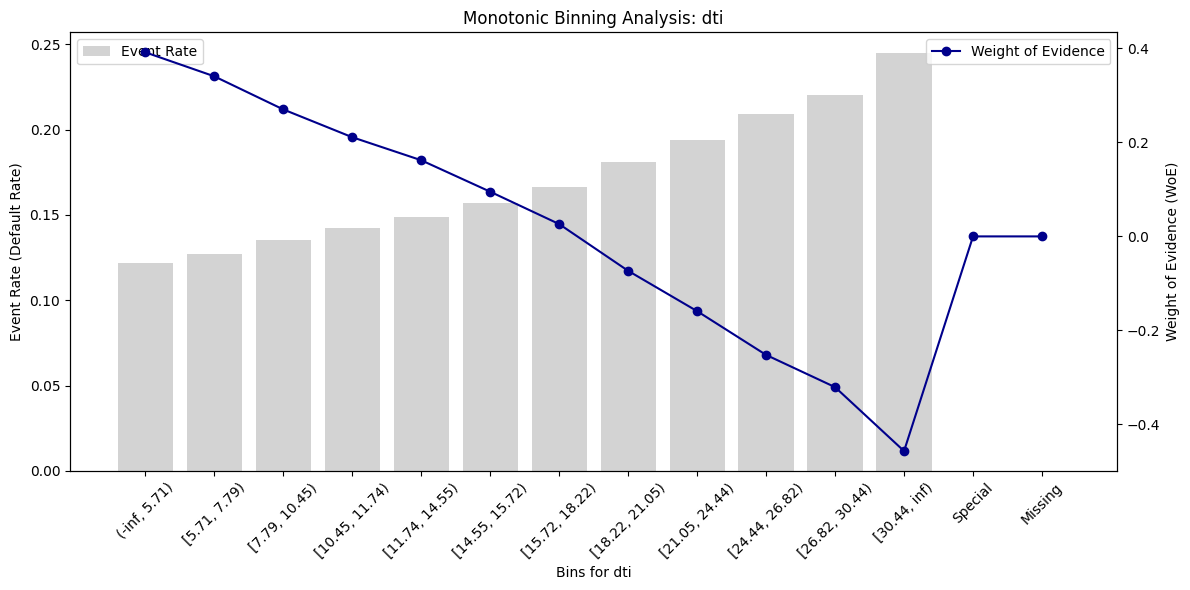

In [22]:
# Plot the binning table for a specified variable

variable = 'dti'
optb = binning_process[variable]
table = optb.binning_table.build()

# Remove the 'Totals' row
plot_table = table.iloc[:-1, :].copy()

# Ensure 'Bin' is treated as string for categorical plotting
bin_labels = plot_table['Bin'].astype(str).tolist()
x_pos = np.arange(len(bin_labels))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Use x_pos for bar placement
ax1.bar(x_pos, plot_table['Event rate'], color='lightgrey', label='Event Rate')
ax1.set_ylabel('Event Rate (Default Rate)')
ax1.set_xlabel(f'Bins for {variable}')

# Align xticks with labels
ax1.set_xticks(x_pos)
ax1.set_xticklabels(bin_labels, rotation=45)

# Line chart for WoE
ax2 = ax1.twinx()
ax2.plot(x_pos, plot_table['WoE'], marker='o', color='darkblue', label='Weight of Evidence')
ax2.set_ylabel('Weight of Evidence (WoE)')

plt.title(f'Monotonic Binning Analysis: {variable}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# Fitting Logistic model

y_train = X_train_woe['target']


X_train_final = X_train_woe.drop(columns=['target'])

if 'const' not in X_train_final.columns:
    X_train_final = sm.add_constant(X_train_final)

def backward_elimination(X, y, significance_level=0.05):
    """
    Repeatedly fits a Logit model and removes the least significant variable
    until all variables have a p-value < significance_level.
    """
    if 'const' not in X.columns:
        X = sm.add_constant(X)
    
    features = list(X.columns)
    
    while True:
        model = sm.Logit(y, X[features]).fit(disp=0)
        
        p_values = model.pvalues
        
        max_p_value = p_values.max()
        max_p_feature = p_values.idxmax()
        
        if max_p_value > significance_level:
            print(f"Dropping '{max_p_feature}' with p-value: {max_p_value:.4f}")
            features.remove(max_p_feature)
            
            if max_p_feature == 'const':
                 print("WARNING: Intercept was statistically insignificant. Consider scaling data or keeping it anyway.")
        else:
            print("\nAll remaining variables are significant!")
            break
            
    final_model = sm.Logit(y, X[features]).fit()
    return final_model, features

model, kept_features = backward_elimination(X_train_final, y_train)

X_oot_final = X_oot_woe

if 'const' not in X_oot_final.columns:
    X_oot_final = sm.add_constant(X_oot_final)

if 'const' not in X_train_final.columns:
    X_train_final = sm.add_constant(X_train_final)

X_oot_final = X_oot_final[kept_features]
X_train_final = X_train_final[kept_features]


print(model.summary())

LinAlgError: Singular matrix

In [ ]:
# Calculating average default rate
y_pred_probs = model.predict(X_train_final)
avg_pred_pd = np.mean(y_pred_probs)
print(f"Initial Average PD: {avg_pred_pd:.4%}")

# Calculate annual default rates
df_train['issue_year'] = issue_dates_train
annual_stats = df_train.groupby('issue_year')['target'].agg(['mean', 'count'])
lra_rate = annual_stats['mean'].mean()
df_train.drop(columns = ['issue_year'])
print(f"Long-Run Average (LRA) Default Rate: {lra_rate:.4%}")

# Determining margin of conservatism
moc_buffer = 0.05
target_calibration_rate = lra_rate + moc_buffer

# Calculate target default rate and delta
target_calibration_rate = np.clip(target_calibration_rate, 1e-9, 1 - 1e-9)
avg_pred_pd_pit = np.clip(avg_pred_pd, 1e-9, 1 - 1e-9)

delta = np.log(target_calibration_rate / (1 - target_calibration_rate)) - np.log(avg_pred_pd_pit / (1 - avg_pred_pd_pit))
print(f"Calibration Delta (Log-Odds Shift): {delta:.4f}")

if 'const' in model.params:
    model.params['const'] += delta
else:
    raise ValueError("Model missing 'const' column for intercept adjustment.")

y_pred_probs_ttc = model.predict(X_train_final)
print(f"New Calibrated Average PD: {y_pred_probs_ttc.mean():.4%}")

Initial Average PD: 22.5071%
Long-Run Average (LRA) Default Rate: 17.5071%
Calibration Delta (Log-Odds Shift): 0.0000
New Calibrated Average PD: 22.5071%


In [ ]:
# Scorecard scaling parameters

target_score = 600
target_odds = 50
points_duble_odds = 20

# Calculate Factor and Offset
factor = points_duble_odds / np.log(2)
offset = target_score - (factor * np.log(target_odds))

print(f"Factor: {factor:.4f}")
print(f"Offset: {offset:.4f}")

Factor: 28.8539
Offset: 487.1229


In [ ]:
# Generate scores for OOT validation data

# Extract Log-Odds
log_odds = np.dot(X_oot_final, model.params)

# Points to Double Odds (PDO) Scaling
df_oot_scored = df_oot.copy()
df_oot_scored['score'] = (offset - (factor * log_odds)).round().astype(int)

# Probability of Default (PD)
df_oot_scored['pd_prob'] = model.predict(X_oot_final)
df_oot_scored['pd_prob'] = np.maximum(df_oot_scored['pd_prob'], 0.0005)

# Clean and Describe
df_oot_scored = df_oot_scored.dropna(subset=['pd_prob'])

print("\n--- OOT Score Distribution ---")
print(df_oot_scored['score'].describe())


--- OOT Score Distribution ---
count    894290.000000
mean        528.742928
std          18.360615
min         461.000000
25%         517.000000
50%         530.000000
75%         542.000000
max         591.000000
Name: score, dtype: float64


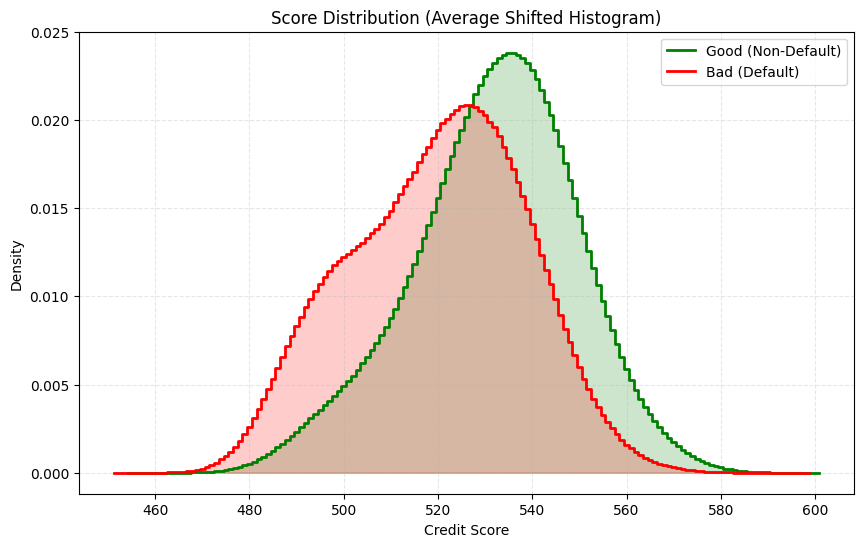

In [ ]:

def plot_ash(data, bin_width, m=10, color='blue', label='ASH'):
    """
    Plots an Average Shifted Histogram (ASH).
    
    Parameters:
    - data: Array of values (scores)
    - bin_width: The width of the base histogram bins (h)
    - m: Number of shifts (higher = smoother)
    """
    # Define the small sub-bin width (delta)
    delta = bin_width / m
    
    # Compute counts in these tiny bins
    min_val = np.min(data) - bin_width
    max_val = np.max(data) + bin_width
    n_bins = int(np.ceil((max_val - min_val) / delta))
    
    counts, edges = np.histogram(data, bins=n_bins, range=(min_val, max_val))
    

    window = np.ones(m) / m 
    ash_counts = np.convolve(counts, window, mode='same')

    ash_density = ash_counts / (len(data) * delta) 
    
    centers = (edges[:-1] + edges[1:]) / 2
    plt.step(centers, ash_density, where='mid', label=label, color=color, linewidth=2)
    plt.fill_between(centers, ash_density, step='mid', alpha=0.2, color=color)

plt.figure(figsize=(10, 6))

bin_width = 10
m = 20

# Good Loans (Green)
plot_ash(df_oot_scored[df_oot_scored['target']==0]['score'], 
         bin_width=bin_width, m=m, color='green', label='Good (Non-Default)')

# Bad Loans (Red)
plot_ash(df_oot_scored[df_oot_scored['target']==1]['score'], 
         bin_width=bin_width, m=m, color='red', label='Bad (Default)')

plt.title('Score Distribution (Average Shifted Histogram)')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [ ]:
def calculate_ks_metric(df, target_col='target', prob_col='pd_prob'):
    """
    Calculates the Kolmogorov-Smirnov (KS) statistic using Scipy

    Measures the maximum separation between the cumulative distribution 
    functions of Goods (Non-Events) and Bads (Events)

    Args:
        df (pd.DataFrame): The dataframe containing target labels and predicted probabilities
        target_col (str, optional): Name of the binary target column. Defaults to 'target'
        prob_col (str, optional): Name of the predicted probability column. Defaults to 'pd_prob'

    Returns:
        float: The KS statistic (D), representing the maximum distance between the two distributions
    """


    # Separate the probabilities for Goods and Bads
    probs_bad = df[df[target_col] == 1][prob_col]
    probs_good = df[df[target_col] == 0][prob_col]
    
    # Calculate KS
    ks_stat, p_value = ks_2samp(probs_bad, probs_good)
    
    return ks_stat, p_value

ks_value, p_value = calculate_ks_metric(df_oot_scored)
print("KS test value: ", ks_value)
print("KS test p-value: ", p_value)

KS test value:  0.2567274363768754
KS test p-value:  0.0


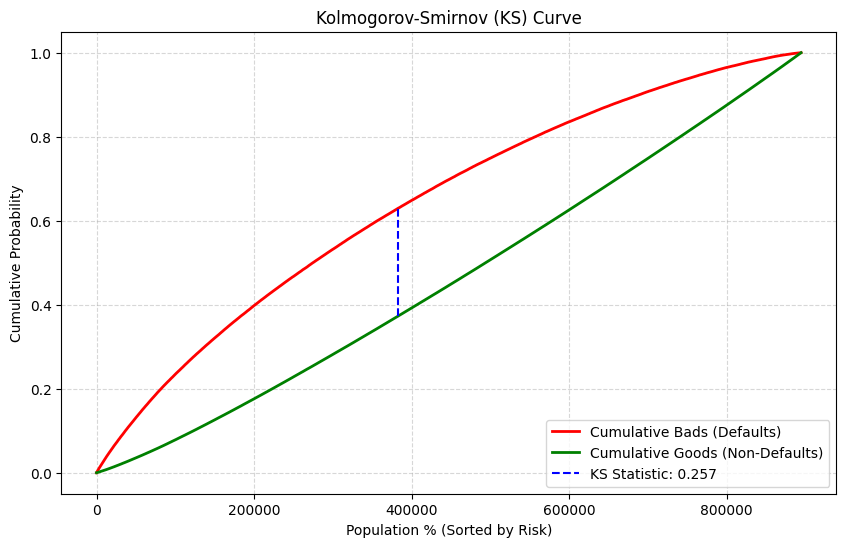

In [ ]:
# Generate KS plot

# Sort by predicted probability
df_sorted = df_oot_scored.sort_values(by='pd_prob', ascending=False).reset_index(drop=True)

# Calculate Cumulative Counts
df_sorted['cum_bad'] = df_sorted['target'].cumsum()
df_sorted['cum_good'] = (1 - df_sorted['target']).cumsum()

df_sorted['cum_bad_pct'] = df_sorted['cum_bad'] / df_sorted['target'].sum()
df_sorted['cum_good_pct'] = df_sorted['cum_good'] / (1 - df_sorted['target']).sum()

df_sorted['ks_diff'] = abs(df_sorted['cum_bad_pct'] - df_sorted['cum_good_pct'])

max_ks_row = df_sorted.loc[df_sorted['ks_diff'].idxmax()]


# Plotting
plt.figure(figsize=(10, 6))

# Plot CDF
plt.plot(df_sorted['cum_bad_pct'], label='Cumulative Bads (Defaults)', color='red', linewidth=2)
plt.plot(df_sorted['cum_good_pct'], label='Cumulative Goods (Non-Defaults)', color='green', linewidth=2)

# Plot the KS Vertical Line
plt.vlines(x=max_ks_row.name, ymin=max_ks_row['cum_good_pct'], ymax=max_ks_row['cum_bad_pct'], 
           colors='blue', linestyles='dashed', label=f'KS Statistic: {ks_value:.3f}')

plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.xlabel('Population % (Sorted by Risk)')
plt.ylabel('Cumulative Probability')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [ ]:
# Use df_oot_scored, where you saved the probabilities earlier
auc = roc_auc_score(df_oot_scored['target'], df_oot_scored['pd_prob'])
gini = 2 * auc - 1

print(f"AUC: {auc:.4f}")
print(f"Gini: {gini:.4f}")

AUC: 0.6801
Gini: 0.3603


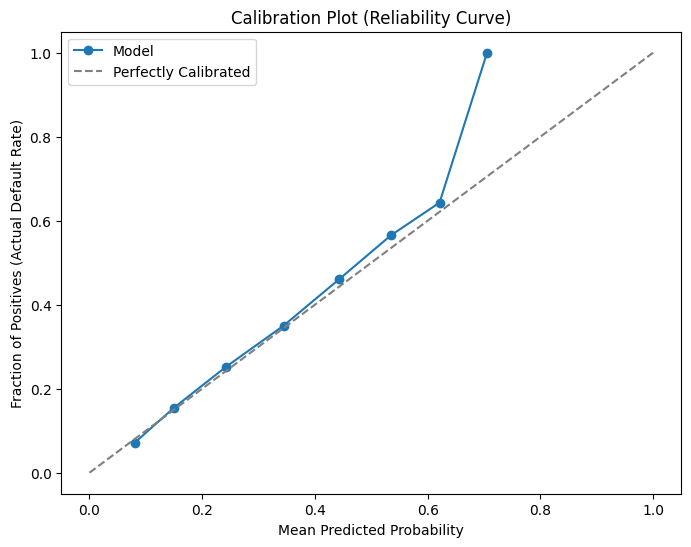

In [ ]:
prob_true, prob_pred = calibration_curve(df_oot_scored['target'], df_oot_scored['pd_prob'], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Actual Default Rate)')
plt.title('Calibration Plot (Reliability Curve)')
plt.legend()
plt.show()

In [ ]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables'''
    
    def psi(expected_array, actual_array, buckets):
        # Define Breakpoints
        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            # Use unique breakpoints to avoid "monotonically increasing" errors
            breakpoints = np.unique(np.percentile(expected_array, breakpoints))
        
        # Calculate Frequencies
        # We clip actuals to ensure they fall within the expected range        
        min_val = expected_array.min()
        max_val = expected_array.max()
        actual_array_clipped = np.clip(actual_array, min_val, max_val)
        
        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array_clipped, breakpoints)[0] / len(actual_array)

        # Vectorized PSI Calculation (Fixes the DeprecationWarning)
        expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
        actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
        
        # Calculate for entire array at once (No loop!)
        psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
        
        return np.sum(psi_values)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    if len(expected.shape) == 1:
        psi_values = psi(expected, actual, buckets)
    elif axis == 0:
        for i in range(0, expected.shape[1]):
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
    elif axis == 1:
        for i in range(0, expected.shape[0]):
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return psi_values

log_odds_train = np.dot(X_train_final, model.params)

expected_scores = (offset - (factor * log_odds_train)).round().astype(int)

actual_scores = df_oot_scored['score']

psi_score = calculate_psi(expected_scores.values if hasattr(expected_scores, 'values') else expected_scores, 
                          actual_scores.values if hasattr(actual_scores, 'values') else actual_scores, 
                          buckets=10)

psi_score = calculate_psi(expected_scores, actual_scores, buckets=10)
print(f"System Stability Index (PSI): {psi_score:.4f}")

System Stability Index (PSI): 0.0263


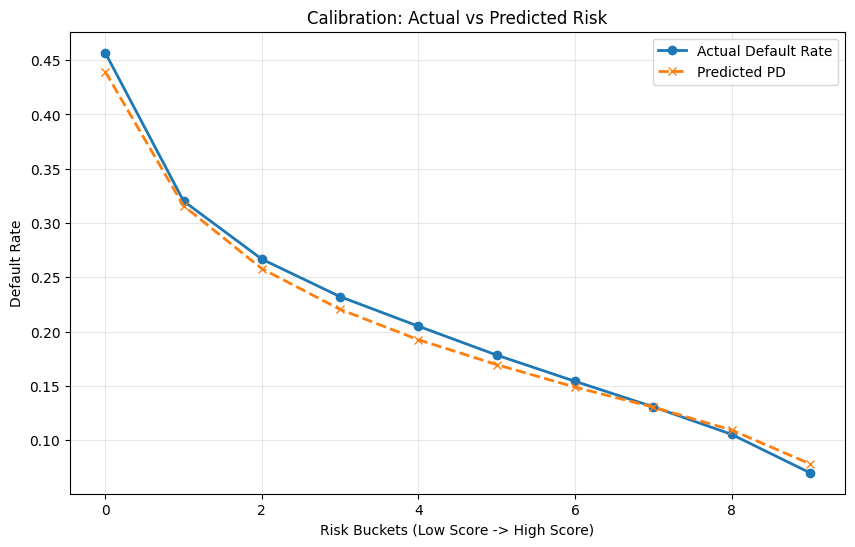

                  Actual_DR  Predicted_PD  Volume
bucket                                           
(460.999, 503.0]   0.456879      0.439408   92924
(503.0, 514.0]     0.320231      0.315847   97005
(514.0, 520.0]     0.266691      0.257920   80494
(520.0, 526.0]     0.232113      0.220371  103148
(526.0, 530.0]     0.204890      0.192429   78369
(530.0, 535.0]     0.178290      0.169492  101991
(535.0, 539.0]     0.154138      0.148761   79299
(539.0, 544.0]     0.130603      0.130326   87992
(544.0, 551.0]     0.105243      0.109251   88234
(551.0, 591.0]     0.069889      0.078183   84834


In [ ]:
# Create risk buckets (deciles)
df_oot_scored['bucket'] = pd.qcut(df_oot_scored['score'], q=10, duplicates='drop')

# Calculate Average PD vs Actual Default Rate per bucket
calibration = df_oot_scored.groupby('bucket', observed=False).agg({
    'target': 'mean',
    'pd_prob': 'mean',
    'score': 'count'
})

# Rename for clarity
calibration.columns = ['Actual_DR', 'Predicted_PD', 'Volume']

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(calibration)), calibration['Actual_DR'], marker='o', label='Actual Default Rate', linewidth=2)
plt.plot(range(len(calibration)), calibration['Predicted_PD'], marker='x', linestyle='--', label='Predicted PD', linewidth=2)
plt.title("Calibration: Actual vs Predicted Risk")
plt.xlabel("Risk Buckets (Low Score -> High Score)")
plt.ylabel("Default Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(calibration)